In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib import animation, rc
from lbow.transient import HalfPlaneModel, OneLayerModel

In [3]:
rc('animation', html='html5')

# Transition to steady state atmospheric gravity waves

This notebook calculates the response of atmospheric gravity waves to a step function in time to illustrate the transition of the wave field from no excitation to a steady state wave field. Note that, because we use the Fourier transform in time, the temporal shape function needs to be periodic, so we consider a long pulse rather than a true step function.

Copyright 2022 Dries Allaerts

Licensed under the Apache License, Version 2.0.

## Set-up

Define smooth step function

$\mathcal{S}(x)=\begin{cases}
0 & x \le 0\\
1/[1+\exp\left(\frac{1}{x-1} + \frac{1}{x}\right)] & 0 \lt x \lt 1 \\
1 & x \ge 1
\end{cases}$

In [4]:
def S(x):
    S = np.zeros(x.shape)
    id = np.where((x>0) & (x<1))
    S[id] = 1/(1+np.exp(1/(x[id]-1)+1/x[id]))
    S[x>=1] = 1
    return S

### Input parameters

Flow parameters: wind speed U and Brunt Vaisala frequency N

In [5]:
U = 10   # Wind speed [m/s]
N = 0.01 # Brunt-Vaisala frequency [1/s]

Hill shape $h\left(x,t\right) = h_{max}\exp\left(-\frac{x^2}{2L^2}\right)\Pi\left(t\right)$,

with the pulse function defined as $\Pi\left(t\right)=\mathcal{S}\left(\frac{t}{\tau}\right)-\mathcal{S}\left(\frac{t-W}{\tau}+1\right)$

In [6]:
L = 1000.0    # Characteristic width of the hill [m]
hmax = 100.0  # Height of the hill [m]
W = 15 * 3600 # Width of the pulse [s]
tau = 360     # Characteristic time scale (determine rise speed of the pulse)[s]

# Shape functions of the hill
hx = lambda x: hmax*np.exp(-(x/L)**2/2)
ht = lambda t: S((t)/tau)-S((t-W)/tau+1)

Numerical parameters

In [7]:
Lx = 100.0e3  # Length of the numerical domain [m]
Nx = 250      # Number of grid points in then horizontal direction

In [8]:
T = 60 * 3600 # Time window [s]
Nt = 1440     # Number of grid points in the temporal dimension

Parameters for visualization

In [9]:
Lz = 15.0e3 # Height up to which solution is calculated [m]
Nz = 151    # Number of vertical levels to be used

### Numerical grid

In [10]:
xs,dx = np.linspace(-Lx/2,Lx/2,Nx,endpoint=False,retstep=True)
print('Horizontal grid resolution is {} m'.format(dx))

Horizontal grid resolution is 400.0 m


In [11]:
ts,dt = np.linspace(-T/2,T/2,Nt,endpoint=False,retstep=True)
print('Temporal resolution is {} s'.format(dt))

Temporal resolution is 150.0 s


In [12]:
zs,dz = np.linspace(0,Lz,Nz,retstep=True)
print('Vertical resolution is {} m'.format(dz))

Vertical resolution is 100.0 m


In [13]:
Xs,Ts = np.meshgrid(xs,ts,indexing='ij')

### Model

In [14]:
model = HalfPlaneModel(Xs,Ts,hx(Xs)*ht(Ts),U,N)

### Visualize hill

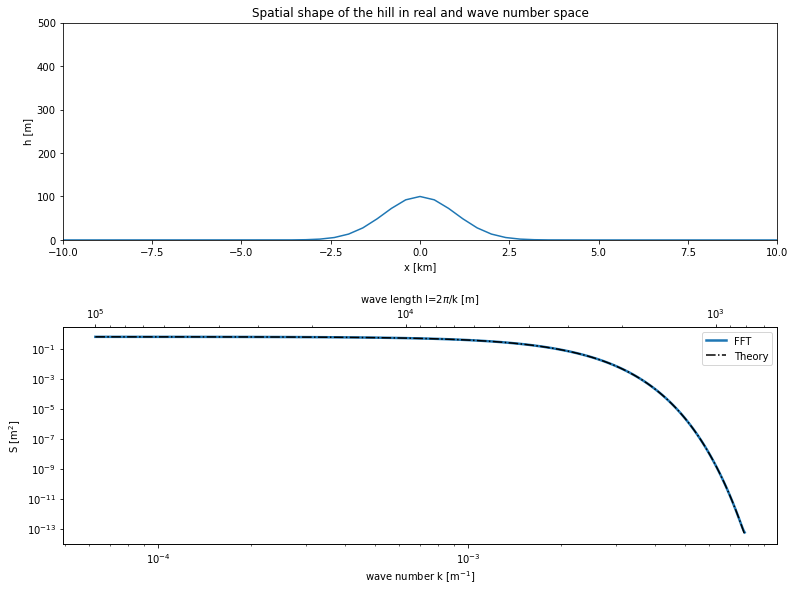

In [15]:
f,ax = plt.subplots(2,1,figsize=(12.8,9.6))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(xs/1.e3,hx(xs))
ax[1].loglog(model.k[1:int(Nx/2),0],np.abs(model.hc[1:int(Nx/2),0]),linewidth=2.5,label='FFT')
_ = ax[0].set(xlim=[-10,10],ylim=[0,500],xlabel='x [km]',ylabel='h [m]',
              title='Spatial shape of the hill in real and wave number space')
_ = ax[1].set(xlabel=r'wave number k [m$^{-1}$]',ylabel=r'S [m$^2$]')

# Theoretical Fourier transform pair
scale = np.mean(hx(Xs)*ht(Ts))
ax[1].loglog(model.k[1:int(Nx/2),0],scale*np.exp(-L**2*model.k[1:int(Nx/2),0]**2/2),'-.k',label='Theory')
ax[1].legend()
ax2 = ax[1].twiny()
ax2.set_xscale('log')
ax2.set_xlabel(r'wave length l=2$\pi$/k [m]')
_ = ax2.set_xlim((2*np.pi/ax[1].get_xlim()[0],2*np.pi/ax[1].get_xlim()[1]))

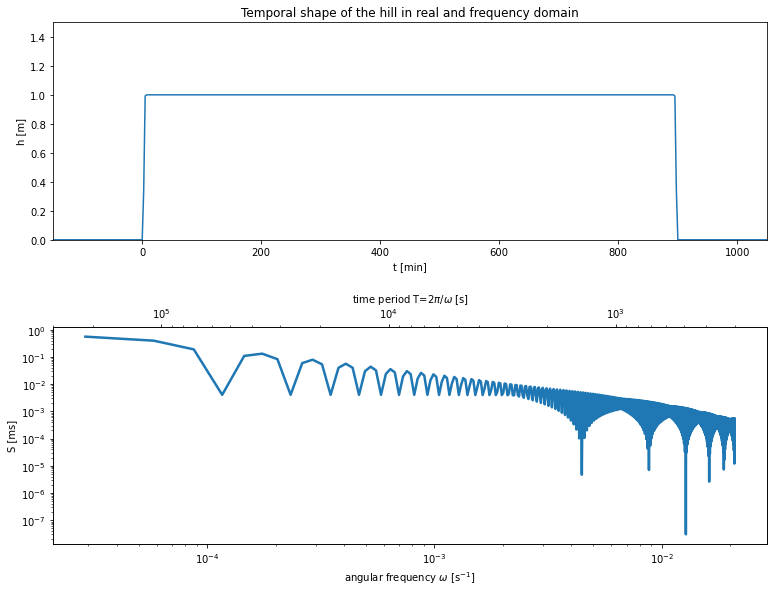

In [16]:
f,ax = plt.subplots(2,1,figsize=(12.8,9.6))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(ts/60,ht(ts))
ax[1].loglog(-model.omega[0,1:],np.abs(model.hc[0,1:]),linewidth=2.5,label='FFT')
_ = ax[0].set(xlim=[-150,1050],ylim=[0,1.5],xlabel='t [min]',ylabel='h [m]',
              title='Temporal shape of the hill in real and frequency domain')
_ = ax[1].set(xlabel=r'angular frequency $\omega$ [s$^{-1}$]',ylabel=r'S [ms]')

ax2 = ax[1].twiny()
ax2.set_xscale('log')
ax2.set_xlabel(r'time period T=2$\pi$/$\omega$ [s]')
_ = ax2.set_xlim((2*np.pi/ax[1].get_xlim()[0],2*np.pi/ax[1].get_xlim()[1]))

Note that $t=0$ corresponds to the start of the step function

## Solve flow problem

In [17]:
%time eta = model.solve('eta',zs)

CPU times: user 2.9 s, sys: 1.86 s, total: 4.76 s
Wall time: 5.94 s


In [18]:
%time w = model.solve('w',zs)

CPU times: user 2.63 s, sys: 1.42 s, total: 4.04 s
Wall time: 5.19 s


## Visualization

### Contourplots of vertical displacement at various time instances

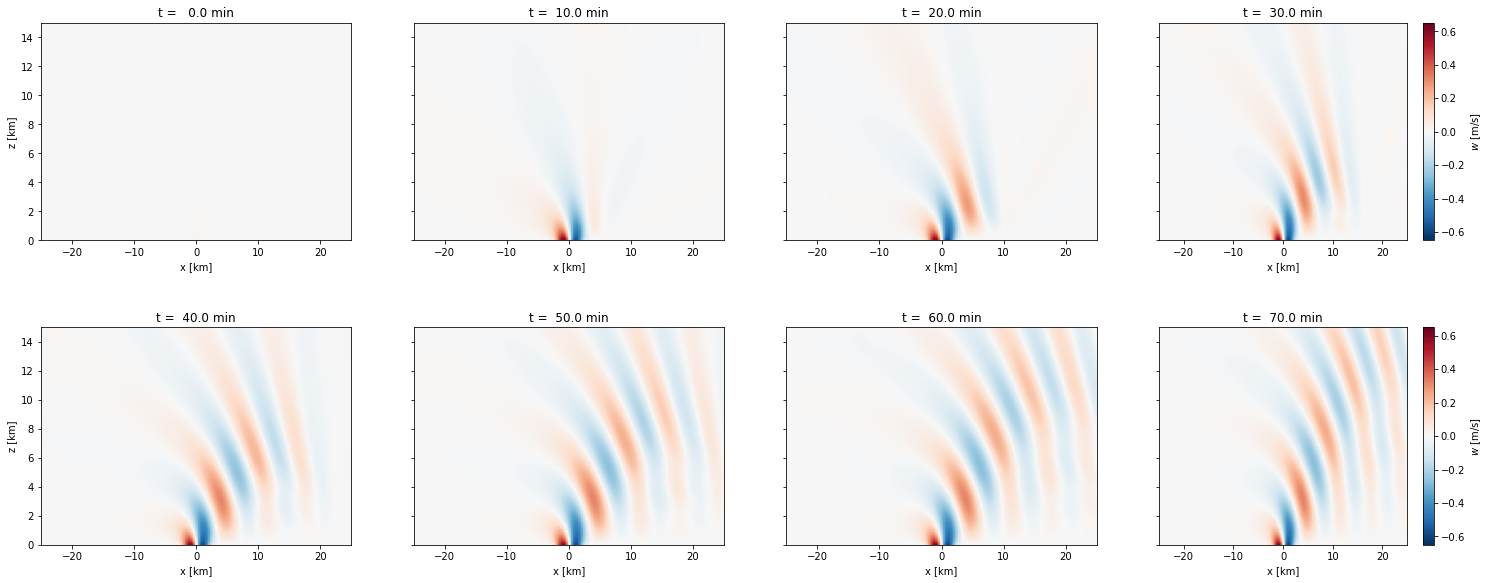

In [19]:
tindices = [720,724,728,732,736,740,744,748]
f,ax=plt.subplots(2,int(len(tindices)/2),sharey=True,figsize=(6.4*len(tindices)/2,9.6))
f.subplots_adjust(hspace=0.4)
ax = ax.ravel()

# Plot displacement in left axis
for axi,tindex in enumerate(tindices):
    im=ax[axi].imshow(
             w[...,tindex],
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.,vmin=-0.65,vmax=0.65))
    _ = ax[axi].set(xlim=[-25,25],ylim=[0,15],xlabel='x [km]',title='t = {:5.1f} min'.format(ts[tindex]/60))
cbar = f.colorbar(im,ax=ax[-1],shrink=1.0,label=r'$w$ [m/s]')
cbar = f.colorbar(im,ax=ax[int(len(tindices)/2)-1],shrink=1.0,label=r'$w$ [m/s]')
_ = ax[0].set(ylabel='z [km]')
_ = ax[int(len(tindices)/2)].set(ylabel='z [km]')

### Animation of the vertical displacement over time

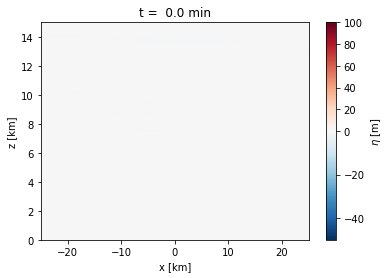

In [20]:
tstart = 720
frames = range(0,55,1)
f, ax = plt.subplots()
cax = ax.imshow(eta[...,tstart],
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.,vmin=-50,vmax=100))
cbar = f.colorbar(cax,ax=ax,shrink=1.0,label=r'$\eta$ [m]')
_ = ax.set(xlim=[-25,25],ylim=[0,15],xlabel='x [km]',ylabel='z [km]',
           title='t = {:4.1f} min'.format(ts[tstart]/60))

def animate(i):
    cax.set_array(eta[...,tstart+i])
    _ = ax.set(title='t = {:4.1f} min'.format(ts[tstart+i]/60))

anim = animation.FuncAnimation(f, animate, interval=400, frames=frames)

In [21]:
anim